# Convolutional Autoencode

In [45]:
from torchvision import datasets
from torchvision import transforms

train_data = datasets.FashionMNIST(root="data", train=True, download=True, transform=transforms.ToTensor())
test_data = datasets.FashionMNIST(root="data", train=False, download=True, transform=transforms.ToTensor())

In [46]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(dataset=train_data, batch_size=32, shuffle=True)
test_dataloader = DataLoader(dataset=test_data, batch_size=32, shuffle=False)

In [47]:
import torch
import torch.nn as nn

class AutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1, stride=2),
            nn.ReLU(),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1, stride=2),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(32 * 7 * 7, 16),  # Bottleneck layer
            nn.ReLU()
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(16, 32 * 7 * 7),
            nn.ReLU()
        )

        # Transposed convolution layers
        self.deconv_layers = nn.Sequential(
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        # print("Encoded Shape:", x.shape)  # (Batch, 16)

        x = self.decoder(x)  
        x = x.view(-1, 32, 7, 7)  # Reshape before transposed convolutions
        x = self.deconv_layers(x)

        # print("Decoded Shape:", x.shape)  # Expected: (Batch, 1, 28, 28)
        return x


In [48]:
import torch
dummy_image = torch.rand((32,1,28,28))
model = AutoEncoder()
# model(dummy_image)

from torchinfo import summary

summary(model, input_size=(32,1,28,28))

Layer (type:depth-idx)                   Output Shape              Param #
AutoEncoder                              [32, 1, 28, 28]           --
├─Sequential: 1-1                        [32, 16]                  --
│    └─Conv2d: 2-1                       [32, 16, 14, 14]          160
│    └─ReLU: 2-2                         [32, 16, 14, 14]          --
│    └─Conv2d: 2-3                       [32, 32, 7, 7]            4,640
│    └─ReLU: 2-4                         [32, 32, 7, 7]            --
│    └─Flatten: 2-5                      [32, 1568]                --
│    └─Linear: 2-6                       [32, 16]                  25,104
│    └─ReLU: 2-7                         [32, 16]                  --
├─Sequential: 1-2                        [32, 1568]                --
│    └─Linear: 2-8                       [32, 1568]                26,656
│    └─ReLU: 2-9                         [32, 1568]                --
├─Sequential: 1-3                        [32, 1, 28, 28]           --
│  

In [49]:
# loss_fn = nn.CrossEntropyLoss()
# since output is an image itself aso use mseloss
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)

In [50]:
from tqdm.auto import tqdm
epochs = 10
for epoch in tqdm(range(epochs)):
    train_loss = 0
    model.train()
    for img, label in tqdm(train_dataloader, leave=False):
        # img = img.view(img.size(0), -1)
        # print(img.shape)
        y_pred = model(img)
        loss = loss_fn(y_pred, img)
        train_loss += loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    train_loss /= len(train_dataloader)
    print(f"Loss: {loss.item():.4f}")


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

Loss: 0.0177


  0%|          | 0/1875 [00:00<?, ?it/s]

Loss: 0.0231


  0%|          | 0/1875 [00:00<?, ?it/s]

Loss: 0.0196


  0%|          | 0/1875 [00:00<?, ?it/s]

Loss: 0.0248


  0%|          | 0/1875 [00:00<?, ?it/s]

Loss: 0.0219


  0%|          | 0/1875 [00:00<?, ?it/s]

Loss: 0.0191


  0%|          | 0/1875 [00:00<?, ?it/s]

Loss: 0.0193


  0%|          | 0/1875 [00:00<?, ?it/s]

Loss: 0.0245


  0%|          | 0/1875 [00:00<?, ?it/s]

Loss: 0.0176


  0%|          | 0/1875 [00:00<?, ?it/s]

Loss: 0.0202


In [51]:
model.eval()
test_loss = 0
with torch.no_grad():  # No gradients needed during evaluation
    for img, _ in tqdm(test_dataloader, leave=False):
        # img = img.flatten(start_dim=1) # Flatten images
        y_pred = model(img)
        loss = loss_fn(y_pred, img)  # Compare with original input
        test_loss += loss.item()

test_loss /= len(test_dataloader)
print(f"Test Loss: {test_loss:.4f}")

  0%|          | 0/313 [00:00<?, ?it/s]

Test Loss: 0.0204


--------------


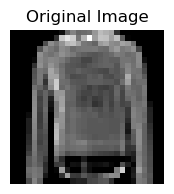

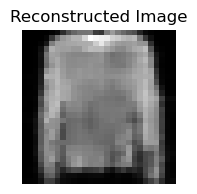

--------------


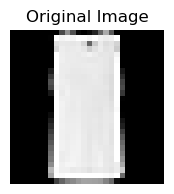

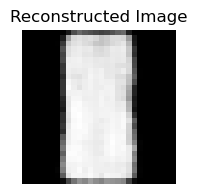

--------------


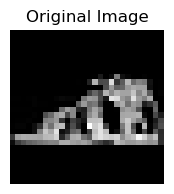

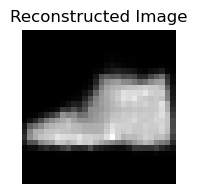

--------------


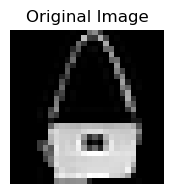

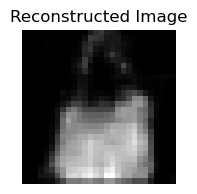

--------------


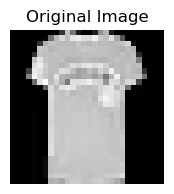

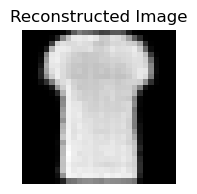

--------------


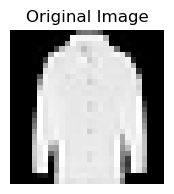

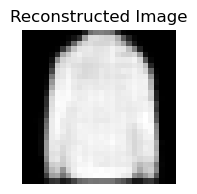

In [52]:
import matplotlib.pyplot as plt
img, label = next(iter(test_dataloader))
# img = img.flatten(start_dim=1)

# Pass through the model
with torch.no_grad():
    reconstructed = model(img)

# img = img.view(-1, 1, 28, 28)
# reconstructed = reconstructed.view(-1, 1, 28, 28)

for i in range(6):
    print("--------------")
    random_idx = torch.randint(0,32,size=[1])
    getorgimg = img[random_idx]
    getreimg = reconstructed[random_idx]

    plt.figure(figsize=(2,2))
    plt.imshow(getorgimg.squeeze(), cmap="gray")
    plt.title("Original Image")
    plt.axis("off")
    plt.show()

    plt.figure(figsize=(2,2))
    plt.imshow(getreimg.squeeze(), cmap="gray")
    plt.title("Reconstructed Image")
    plt.axis("off")
    plt.show()
